<a href="https://colab.research.google.com/github/KarelZe/thesis/blob/baseline/notebooks/3.0-mb-feature_engineering_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install catboost==1.1
!pip install gcsfs==2022.10.0
!pip install numpy==1.23.4
!pip install pandas==1.5.1
!pip install scikit-learn==1.1.3
!pip install seaborn==0.12.1
!pip install wandb==0.13.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement numpy==1.23.4 (from versions: 1.3.0, 1.4.1, 1.5.0, 1.5.1, 1.6.0, 1.6.1, 1.6.2, 1.7.0, 1.7.1, 1.7.2, 1.8.0, 1.8.1, 1.8.2, 1.9.0, 1.9.1, 1.9.2, 1.9.3, 1.10.0.post2, 1.10.1, 1.10.2, 1.10.4, 1.11.0, 1.11.1, 1.11.2, 1.11.3, 1.12.0, 1.12.1, 1.13.0rc1, 1.13.0rc2, 1.13.0, 1.13.1, 1.13.3, 1.14.0rc1, 1.14.0, 1.14.1, 1.14.2, 1.14.3, 1.14.4, 1.14.5, 1.14.6, 1.15.0rc1, 1.15.0rc2, 1.15.0, 1.15.1, 1.15.2, 1.15.3, 1.15.4, 1.16.0rc1, 1.16.0rc2, 1.16.0, 1.16.1, 1.16.2, 1.16.3, 1.16.4, 1.16.5, 1.16.6, 1.17.0rc1, 1.17.0rc2, 1.17.0, 1.17.1, 1.17.2, 1.17.3, 1.17.4, 1.17.5, 1.18.0rc1, 1.18.0, 1.18.1, 1.18.2, 1.18.3, 1.18.4, 1.18.5, 1.19.0rc1, 1.19.0rc2, 1

In [5]:
import os
import random

from catboost import CatBoostClassifier

import gcsfs
import google.auth
from google.colab import auth, output

import numpy as np
import pandas as pd

from sklearn.preprocessing import Binarizer, StandardScaler

import seaborn as sns

from tqdm.notebook import tqdm
import wandb

In [6]:
# connect to weights and biases
run = wandb.init(project="thesis", job_type="dataset-creation", entity="fbv")
dataset = wandb.Artifact(name='train_val_test', type="preprocessed_data")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [7]:
# connect to google cloud storage
auth.authenticate_user()
credentials, _ = google.auth.default()
fs = gcsfs.GCSFileSystem(project="thesis", token=credentials)
fs_prefix = "gs://"

In [8]:
output.enable_custom_widget_manager()

In [9]:
# set fixed seed
def seed_everything(seed): 
  """ 
  Seeds basic parameters for reproducibility of results 
  """ 
  os.environ["PYTHONHASHSEED"] = str(seed) 
  random.seed(seed)

seed = 42
seed_everything(seed)

In [10]:
train = pd.read_parquet(f"gs://thesis-bucket-option-trade-classification/data/preprocessed/train_set_60.parquet")
val = pd.read_parquet(f"gs://thesis-bucket-option-trade-classification/data/preprocessed/val_set_20.parquet")
test = pd.read_parquet(f"gs://thesis-bucket-option-trade-classification/data/preprocessed/test_set_20.parquet")

In [11]:
train.head(10)

,UNDERLYING_SYMBOL,QUOTE_DATETIME,SEQUENCE_NUMBER,ROOT,EXPIRATION,STRK_PRC,OPTION_TYPE,TRADE_SIZE,TRADE_PRICE,BEST_BID,...,bid_ex,bid_size_ex,ask_size_ex,price_all_lead,price_all_lag,optionid,day_vol,price_ex_lead,price_ex_lag,buy_sell
0,BRCD,2005-05-02 09:30:02,72515,YNU,2006-01-21,2.5,C,10,2.05,1.90,...,1.90,131.0,20.0,1.90,1.90,21060388.0,10.0,1.90,2.10,1
1,SYMC,2005-05-02 09:30:03,65366,SYQ,2005-06-18,15.0,C,10,3.90,3.60,...,NaN,NaN,NaN,4.00,4.00,31624184.0,10.0,4.60,4.00,1
2,SPY,2005-05-02 09:30:03,65373,SWG,2005-05-21,105.0,C,50,11.20,11.10,...,11.10,300.0,300.0,11.80,11.00,31620976.0,50.0,11.90,11.00,-1
3,ADRX,2005-05-02 09:30:03,79195,QAX,2005-06-18,25.0,C,10,0.20,0.00,...,0.00,0.0,86.0,0.15,0.15,31560072.0,10.0,0.15,0.15,1
4,ORCL,2005-05-02 09:30:03,95870,ORQ,2005-12-17,14.0,C,15,0.25,0.30,...,0.25,3356.0,399.0,0.35,0.35,25240212.0,17.0,0.35,0.35,-1
5,YHOO,2005-05-02 09:30:03,73595,YHQ,2005-10-22,35.0,P,26,3.00,2.95,...,2.90,1133.0,256.0,3.10,3.40,24020608.0,46.0,3.10,3.40,-1
6,MATK,2005-05-02 09:30:03,80182,KQT,2005-09-17,65.0,C,2,0.55,0.30,...,0.30,56.0,10.0,0.45,0.45,23989792.0,2.0,0.65,0.45,1
7,VTSS,2005-05-02 09:30:04,80469,VQT,2005-10-22,5.0,P,10,2.75,2.70,...,2.70,10.0,52.0,2.90,2.90,24019950.0,40.0,2.90,2.90,-1
8,ADRX,2005-05-02 09:30:04,80342,QAX,2005-09-17,25.0,C,1,0.60,0.45,...,0.45,94.0,25.0,0.55,0.50,23983374.0,11.0,0.65,0.50,1
9,IVGN,2005-05-02 09:30:04,97063,IUV,2005-08-20,65.0,C,10,11.00,0.00,...,NaN,NaN,NaN,13.80,9.90,23797976.0,10.0,13.80,9.90,1


In [36]:
# randomly sample frac of rows
# frac = 0.2

# train = train.sample(frac=frac, random_state=seed)
# val = val.sample(frac=frac, random_state=seed)
# test = test.sample(frac=frac, random_state=seed)

# unify for common preprocessing
X = pd.concat([train, val, test])

In [37]:
# calculate days to maturity
X['time_to_maturity'] = (X['EXPIRATION'] - X['QUOTE_DATETIME']).dt.days

In [38]:
# apply positional encoding to dates
X["date_month_sin"] = np.sin(2 * np.pi * X['QUOTE_DATETIME'].dt.year / 12)
X["date_month_cos"] = np.cos(2 * np.pi * X['QUOTE_DATETIME'].dt.year / 12)

# # add year
# X["date_year"] = X['QUOTE_DATETIME'].dt.year
# # scaling to range starting at zero up to one
# data["yy"] = data.apply(
#     lambda x: (x.astype(float) - min(x)) / (max(x) - min(x)), axis=0
# )["yy"]

date_columns = ["date_month_sin", "date_month_cos"]

In [39]:
X.dtypes

UNDERLYING_SYMBOL            object
QUOTE_DATETIME       datetime64[ns]
SEQUENCE_NUMBER               int64
ROOT                         object
EXPIRATION           datetime64[ns]
STRK_PRC                    float32
OPTION_TYPE                category
TRADE_SIZE                    int64
TRADE_PRICE                 float32
BEST_BID                    float32
BEST_ASK                    float32
order_id                      int64
ask_ex                      float32
bid_ex                      float32
bid_size_ex                 float32
ask_size_ex                 float32
price_all_lead              float32
price_all_lag               float32
optionid                    float32
day_vol                     float32
price_ex_lead               float32
price_ex_lag                float32
buy_sell                       int8
time_to_maturity              int64
date_month_sin              float64
date_month_cos              float64
dtype: object

In [40]:
# remove problematic features -> see notebook on aversarial validation
X = X.drop(["SEQUENCE_NUMBER", "order_id", "optionid", "EXPIRATION", "QUOTE_DATETIME", "ROOT"], axis=1)

In [41]:
# isolate target
y = X[["buy_sell"]]
X = X.drop(["buy_sell"], axis=1)

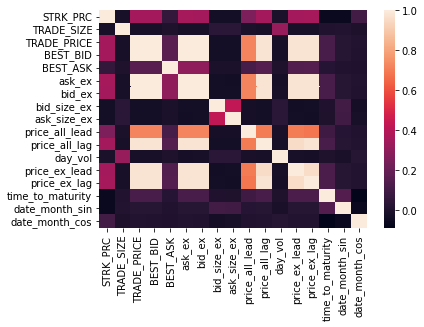

In [42]:
corr = X.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [43]:
# Midspread
mid = 0.5 * (X['ask_ex'] + X['bid_ex'])
X['mid_ex'] = mid

In [44]:
# Absolute distance from mid
X['abs_mid_ex'] = X['TRADE_PRICE'] - mid

In [45]:
# Degree how much Trade size is filled
X['rel_bid_size_ex'] = X['TRADE_SIZE'] / X['bid_size_ex']
X['rel_ask_size_ex'] = X['TRADE_SIZE'] / X['ask_size_ex']

In [46]:
# Calculate sign change from trade
tt = np.where(X['TRADE_PRICE'] > X['price_ex_lead'], 1.0, -1.0)
X['sgn_chg_ex_lead'] = tt

In [47]:
# select categorical e. g., option type and strings e. g., ticker
cat_columns = X.select_dtypes(include=['category', 'object']).columns.tolist()
print(cat_columns)

# binarize categorical similar to Borisov et al.
X[cat_columns] = X[cat_columns].apply(lambda x : pd.factorize(x)[0])

['UNDERLYING_SYMBOL', 'OPTION_TYPE']


In [48]:
# treat inf as nan
X.replace([np.inf, -np.inf], np.nan, inplace=True)

In [49]:
# Fill NaN with 0
X = X.fillna(0)

In [50]:
# separate again for training scaling
X_train = X.loc[train.index, :]
X_val = X.loc[val.index, :]
X_test = X.loc[test.index, :]

y_train = y.loc[train.index, :]
y_val = y.loc[val.index, :]
y_test = y.loc[test.index, :]


In [51]:
# Standardize numerical values
num_columns = X_train.select_dtypes(include=[np.number]).columns.tolist()
num_columns = [x for x in num_columns if x not in cat_columns]
num_columns = [x for x in num_columns if x not in date_columns]
scaler = StandardScaler()

X_train[num_columns] = scaler.fit_transform(X_train[num_columns])
X_val[num_columns] = scaler.transform(X_val[num_columns])
X_test[num_columns] = scaler.transform(X_test[num_columns])

In [59]:
# Train gradient boosting model
model = CatBoostClassifier(max_depth=8, task_type="GPU", random_state=seed, 
                           logging_level= "Silent", cat_features=cat_columns, 
                           od_type= "Iter", grow_policy="Depthwise")
model.fit(X_train, y_train, eval_set=(X_val,y_val), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [60]:
acc_train = model.score(X_train, y_train)
acc_val = model.score(X_val, y_val)
acc_test = model.score(X_test, y_test)

print(f"Accuracy (train): {acc_train}, (val) {acc_val}, and (test) {acc_test}")

Accuracy (train): 0.8525718460524996, (val) 0.7082776173072598, and (test) 0.6747171040409768


In [61]:
# Obtain feature importances
ranks = sorted(list(zip(X.columns, model.feature_importances_)), 
               key=lambda x: x[1], reverse=True) 
for feature, score in ranks: 
  print(f"{feature:10} : {score:0.4f}")

ask_size_ex : 31.7758
bid_size_ex : 29.6473
abs_mid_ex : 19.6143
day_vol    : 4.6019
rel_bid_size_ex : 4.1404
rel_ask_size_ex : 3.6197
TRADE_SIZE : 2.4638
date_month_sin : 0.7460
ask_ex     : 0.7147
BEST_BID   : 0.5441
bid_ex     : 0.4264
BEST_ASK   : 0.3552
time_to_maturity : 0.3451
UNDERLYING_SYMBOL : 0.2590
STRK_PRC   : 0.2575
date_month_cos : 0.1559
price_all_lead : 0.1208
TRADE_PRICE : 0.0759
mid_ex     : 0.0513
price_ex_lead : 0.0478
sgn_chg_ex_lead : 0.0195
price_all_lag : 0.0114
OPTION_TYPE : 0.0035
price_ex_lag : 0.0026


In [31]:
# TODO: Implement hyperparameter search

In [32]:
# TODO: print some metrics

In [ ]:
# TODO: Set up simple robustness checks

## Classical rules

In [ ]:
df.head().T

,34736684,34736685,34736686,34736687,34736688
UNDERLYING_SYMBOL,LINE,LINE,AMZN,TLT,TLT
QUOTE_DATETIME,2015-01-02 09:30:00,2015-01-02 09:30:00,2015-01-02 09:30:00,2015-01-02 09:30:00,2015-01-02 09:30:00
SEQUENCE_NUMBER,74466,67183330,8588013,7331304,7331305
ROOT,LINE,LINE,AMZN,TLT,TLT
EXPIRATION,2015-04-17 00:00:00,2015-04-17 00:00:00,2015-02-20 00:00:00,2015-01-02 00:00:00,2015-01-02 00:00:00
STRK_PRC,9.0,18.0,390.0,124.0,126.0
OPTION_TYPE,C,C,C,P,P
TRADE_SIZE,5,5,1,20,20
TRADE_PRICE,2.14,0.04,1.42,0.01,0.18
BEST_BID,1.8,0.0,0.0,0.0,0.05


In [ ]:
# test if if a lead price is different from the trade price?
sum = (df['TRADE_PRICE'] == df['price_ex_lead']).sum()
print(sum)

0


In [ ]:
# quote rule
mid = 0.5 * (df['ask_ex'] + df['bid_ex'])
qr = np.where(df['TRADE_PRICE'] > mid, 1, np.where(df['TRADE_PRICE'] < mid, -1, np.nan))
df['pred_quote_rule'] = qr

In [ ]:
sum = (df['TRADE_PRICE'] == mid).sum()
print(sum)

632780


In [ ]:
# depth rule p. 14
dr = np.where((df['TRADE_PRICE'] == mid) & (df['ask_size_ex'] > df['bid_size_ex']),1,np.where((df['TRADE_PRICE'] == mid) & (df['ask_size_ex'] < df['bid_size_ex']),-1,np.nan))
df['pred_depth_rule'] = dr

In [ ]:
# tick rule
# FIXME: Disqus with Grauer et al what is used in table 9 ISE or all?
tt = np.where(df['TRADE_PRICE'] > df['price_ex_lead'], 1.0, -1.0)
df['pred_tick_test'] = tt

In [ ]:
# main idea of our new “trade size rule” is that when the trade size matches exactly either the bid or ask quote size, it is likely that the quote came from a customer, the market maker found it attractive and, therefore, decided to fill it completely.
# we propose to classify trades for which the trade size is equal to the quoted bid size as customer buys and those with a trade size equal to the ask size as customer sells.

ts_eq_bid = (df['TRADE_SIZE'] == df['bid_size_ex'])
ts_eq_ask = (df['TRADE_SIZE'] == df['ask_size_ex'])

df['pred_trade_size_quote_rule'] = np.where(ts_eq_bid,1.0, np.where(ts_eq_ask,-1.0, qr))
df['pred_trade_size_tick_test'] = np.where(ts_eq_bid,1.0, np.where(ts_eq_ask,-1.0, tt))

In [ ]:
df['pred_trade_size_depth_rule'] = np.where(ts_eq_bid,1.0, np.where(ts_eq_ask,-1.0, dr))

In [ ]:
# reverse tick rule
df['pred_rev_tick_test'] = np.where(df['TRADE_PRICE'] > df['price_all_lag'], 1.0, -1.0)

In [ ]:
df.head().T

,34736684,34736685,34736686,34736687,34736688
UNDERLYING_SYMBOL,LINE,LINE,AMZN,TLT,TLT
QUOTE_DATETIME,2015-01-02 09:30:00,2015-01-02 09:30:00,2015-01-02 09:30:00,2015-01-02 09:30:00,2015-01-02 09:30:00
SEQUENCE_NUMBER,74466,67183330,8588013,7331304,7331305
ROOT,LINE,LINE,AMZN,TLT,TLT
EXPIRATION,2015-04-17 00:00:00,2015-04-17 00:00:00,2015-02-20 00:00:00,2015-01-02 00:00:00,2015-01-02 00:00:00
STRK_PRC,9.0,18.0,390.0,124.0,126.0
OPTION_TYPE,C,C,C,P,P
TRADE_SIZE,5,5,1,20,20
TRADE_PRICE,2.14,0.04,1.42,0.01,0.18
BEST_BID,1.8,0.0,0.0,0.0,0.05


In [ ]:
# Discuss with C. Grauer how results were calculated in table 9. Assign randomly (table 3) (?)
pred_quote_rule_random = df['pred_quote_rule'].applymap(lambda l: l if not np.isnan(l) else np.random.choice([-1, 1]))

acc = accuracy_score(df['buy_sell'], pred_quote_rule_random)
print(f"{acc:.3%}")

56.073%


In [ ]:
# Discuss with C. Grauer how results were calculated in table 9. Assign randomly (table 3) (?)
pred_trade_size_quote_rule_random = df['pred_trade_size_quote_rule'].applymap(lambda l: l if not np.isnan(l) else np.random.choice([-1, 1]))

acc = accuracy_score(df['buy_sell'], pred_trade_size_quote_rule_random)
print(f"{acc:.3%}")

65.387%


In [ ]:
# Discuss with C. Grauer how results were calculated in table 9. Assign randomly (table 3) (?)
pred_depth_rule_random = df['pred_depth_rule'].map(lambda l: l if not np.isnan(l) else np.random.choice([-1, 1]))

acc = accuracy_score(df['buy_sell'], pred_depth_rule_random)
print(f"{acc:.3%}")

51.728%


In [ ]:
# Discuss with C. Grauer how results were calculated in table 9. Assign randomly (table 3) (?)
pred_trade_size_depth_rule_random = df['pred_trade_size_depth_rule'].map(lambda l: l if not np.isnan(l) else np.random.choice([-1, 1]))

acc = accuracy_score(df['buy_sell'], pred_trade_size_depth_rule_random)
print(f"{acc:.3%}")

56.629%


In [ ]:
acc = accuracy_score(df['buy_sell'], df['pred_trade_size_tick_test'])
print(f"{acc:.3%}")

54.617%


In [ ]:
acc = accuracy_score(df['buy_sell'], df['pred_tick_test'])
print(f"{acc:.3%}")

49.181%


In [ ]:
acc = accuracy_score(df['buy_sell'], df['pred_rev_tick_test'])
print(f"{acc:.3%}")

53.864%
